### Temporal Fusion Transformers

In [104]:
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import torch
from darts import TimeSeries
from darts.metrics import rmse
from sklearn.metrics import mean_squared_error

torch.manual_seed(3407)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

from darts.models import TFTModel 

In [5]:
mm_scaler = StandardScaler()

In [8]:
canada = pd.read_csv('canada.csv')
canada = canada.values[:, 0:3].astype(float)

TRAIN_IDX = int(canada.shape[0]*.5)
VAL_IDX = TRAIN_IDX + int(canada.shape[0]*.1)

In [9]:
canada[:TRAIN_IDX] = mm_scaler.fit_transform(canada[:TRAIN_IDX])
canada[TRAIN_IDX:VAL_IDX] = mm_scaler.transform(canada[TRAIN_IDX:VAL_IDX])
canada_train_val = canada[:VAL_IDX]

time_series = TimeSeries.from_values(canada_train_val)

In [10]:
OUTPUT_STEP = 2  # predict |OUTPUT_STEP| steps as output

parameters = {
    "hidden_continuous_size": [2, 4, 8],
    "lstm_layers": [2, 4],
    "dropout": [0.1, 0.3],   
    "batch_size": [2,4],
    "input_chunk_length": [16,32,64],
    "output_chunk_length": [OUTPUT_STEP],
    "n_epochs": [24],
    "num_attention_heads": [2, 4, 8],   # divisible by number of features
    "add_relative_index": [True]
}

best_model, _, _ = TFTModel.gridsearch(
    parameters = parameters,
    series = time_series[:TRAIN_IDX],
    val_series = time_series[TRAIN_IDX:VAL_IDX],
    metric = rmse,
    n_jobs=16,
    verbose=True)

  0%|          | 0/216 [00:00<?, ?it/s]

[2022-10-01 16:23:33,949] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'hidden_continuous_size': 8, 'lstm_layers': 2, 'dropout': 0.1, 'batch_size': 4, 'input_chunk_length': 32, 'output_chunk_length': 2, 'n_epochs': 24, 'num_attention_heads': 2, 'add_relative_index': True}
[2022-10-01 16:23:33,949] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'hidden_continuous_size': 8, 'lstm_layers': 2, 'dropout': 0.1, 'batch_size': 4, 'input_chunk_length': 32, 'output_chunk_length': 2, 'n_epochs': 24, 'num_attention_heads': 2, 'add_relative_index': True}
2022-10-01 16:23:33 darts.models.forecasting.forecasting_model INFO: Chosen parameters: {'hidden_continuous_size': 8, 'lstm_layers': 2, 'dropout': 0.1, 'batch_size': 4, 'input_chunk_length': 32, 'output_chunk_length': 2, 'n_epochs': 24, 'num_attention_heads': 2, 'add_relative_index': True}


In [11]:
best_model.fit(time_series[:TRAIN_IDX]) 

[2022-10-01 16:23:33,995] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 244 samples.
[2022-10-01 16:23:33,995] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 244 samples.
2022-10-01 16:23:33 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 244 samples.
[2022-10-01 16:23:34,046] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-10-01 16:23:34,046] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-10-01 16:23:34 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-10-01 16:23:34 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-01 16:23:34 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-01 16:23:34 pytor

Training: 0it [00:00, ?it/s]

In [12]:
best_model.save_model('tft_train_val.pth.tar')

In [125]:
best_model = TFTModel.load_model('tft_train_val.pth.tar')

In [126]:
predict = best_model.predict(VAL_IDX-TRAIN_IDX)
print(rmse(predict, time_series[TRAIN_IDX:VAL_IDX]))

2022-10-02 11:15:07 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:07 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:07 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

1.996590845529638


In [127]:
inversed_predict=mm_scaler.inverse_transform(predict.values())

In [128]:
true_value=mm_scaler.inverse_transform(time_series[TRAIN_IDX:VAL_IDX].values())

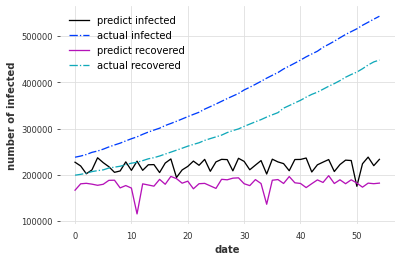

In [129]:
import matplotlib.pyplot as plt

x = range(len(inversed_predict))

plt.plot(x, inversed_predict[:,0], label ='predict infected')
plt.plot(x, true_value[:,0], '-.', label ='actual infected')
plt.plot(x, inversed_predict[:,1], label ='predict recovered')
plt.plot(x, true_value[:,1], '-.', label ='actual recovered')

plt.xlabel("date")
plt.ylabel("number of infected")
plt.legend()
plt.show()

In [130]:
mean_squared_error(inversed_predict[:,0], true_value[:,0], squared=False)

178626.20636945663

In [131]:
canada_test = canada[VAL_IDX-best_model.input_chunk_length:]  # start to predict from here
test_time_transforms = TimeSeries.from_values(mm_scaler.transform(canada_test))

In [132]:
test_prediction = []
for i, data in enumerate(test_time_series):
    # predict    
    y_approx = best_model.predict(1)
    test_prediction.append(y_approx)
    print(i)
    # use test set prior to this step to retrain model
    best_model.fit(test_time_series[:i+best_model.input_chunk_length+best_model.input_chunk_length], epochs=1)

Predicting: 0it [00:00, ?it/s]

[2022-10-02 11:15:08,181] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 31 samples.
[2022-10-02 11:15:08,181] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 31 samples.
2022-10-02 11:15:08 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 31 samples.
2022-10-02 11:15:08 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:08 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:08 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
2022-10-02 11:15:08 pytorch_lightning.callbacks.model_summary INFO: 
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
1  | encoder_vsn   

0


Training: 0it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

[2022-10-02 11:15:08,557] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 32 samples.
[2022-10-02 11:15:08,557] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 32 samples.
2022-10-02 11:15:08 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 32 samples.
2022-10-02 11:15:08 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:08 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:08 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:08,564] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

1


Training: 0it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

[2022-10-02 11:15:08,924] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 33 samples.
[2022-10-02 11:15:08,924] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 33 samples.
2022-10-02 11:15:08 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 33 samples.
2022-10-02 11:15:08 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:08 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:08 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:08,931] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

2


Training: 0it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

[2022-10-02 11:15:09,314] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 34 samples.
[2022-10-02 11:15:09,314] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 34 samples.
2022-10-02 11:15:09 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 34 samples.
2022-10-02 11:15:09 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:09 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:09 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:09,322] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

3


Training: 0it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

[2022-10-02 11:15:09,695] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 35 samples.
[2022-10-02 11:15:09,695] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 35 samples.
2022-10-02 11:15:09 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 35 samples.
2022-10-02 11:15:09 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:09 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:09 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:09,703] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

4


Training: 0it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

[2022-10-02 11:15:10,095] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 36 samples.
[2022-10-02 11:15:10,095] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 36 samples.
2022-10-02 11:15:10 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 36 samples.
2022-10-02 11:15:10 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:10 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:10 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:10,102] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

5


Training: 0it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

[2022-10-02 11:15:10,483] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 37 samples.
[2022-10-02 11:15:10,483] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 37 samples.
2022-10-02 11:15:10 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 37 samples.
2022-10-02 11:15:10 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:10 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:10 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:10,491] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

6


Training: 0it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

[2022-10-02 11:15:10,880] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 38 samples.
[2022-10-02 11:15:10,880] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 38 samples.
2022-10-02 11:15:10 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 38 samples.
2022-10-02 11:15:10 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:10 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:10 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:10,887] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

7


Training: 0it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

[2022-10-02 11:15:11,305] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 39 samples.
[2022-10-02 11:15:11,305] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 39 samples.
2022-10-02 11:15:11 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 39 samples.
2022-10-02 11:15:11 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:11 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:11 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:11,313] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

8


Training: 0it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

[2022-10-02 11:15:11,743] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 40 samples.
[2022-10-02 11:15:11,743] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 40 samples.
2022-10-02 11:15:11 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 40 samples.
2022-10-02 11:15:11 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:11 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:11 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:11,753] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

9


Training: 0it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

[2022-10-02 11:15:12,177] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 41 samples.
[2022-10-02 11:15:12,177] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 41 samples.
2022-10-02 11:15:12 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 41 samples.
2022-10-02 11:15:12 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:12 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:12 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:12,184] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

10


Training: 0it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

[2022-10-02 11:15:12,616] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 42 samples.
[2022-10-02 11:15:12,616] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 42 samples.
2022-10-02 11:15:12 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 42 samples.
2022-10-02 11:15:12 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:12 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:12 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:12,624] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

11


Training: 0it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

[2022-10-02 11:15:13,065] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 43 samples.
[2022-10-02 11:15:13,065] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 43 samples.
2022-10-02 11:15:13 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 43 samples.
2022-10-02 11:15:13 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:13 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:13 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:13,073] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

12


Training: 0it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

[2022-10-02 11:15:13,519] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 44 samples.
[2022-10-02 11:15:13,519] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 44 samples.
2022-10-02 11:15:13 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 44 samples.
2022-10-02 11:15:13 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:13 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:13 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:13,526] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

13


Training: 0it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

[2022-10-02 11:15:13,942] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 45 samples.
[2022-10-02 11:15:13,942] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 45 samples.
2022-10-02 11:15:13 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 45 samples.
2022-10-02 11:15:13 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:13 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:13 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:13,949] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

14


Training: 0it [00:00, ?it/s]

Predicting: 12it [00:00, ?it/s]

[2022-10-02 11:15:14,392] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 46 samples.
[2022-10-02 11:15:14,392] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 46 samples.
2022-10-02 11:15:14 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 46 samples.
2022-10-02 11:15:14 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:14 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:14 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:14,399] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

15


Training: 0it [00:00, ?it/s]

Predicting: 12it [00:00, ?it/s]

[2022-10-02 11:15:14,856] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 47 samples.
[2022-10-02 11:15:14,856] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 47 samples.
2022-10-02 11:15:14 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 47 samples.
2022-10-02 11:15:14 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:14 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:14 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:14,862] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

16


Training: 0it [00:00, ?it/s]

Predicting: 12it [00:00, ?it/s]

[2022-10-02 11:15:15,318] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 48 samples.
[2022-10-02 11:15:15,318] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 48 samples.
2022-10-02 11:15:15 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 48 samples.
2022-10-02 11:15:15 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:15 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:15 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:15,325] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

17


Training: 0it [00:00, ?it/s]

Predicting: 12it [00:00, ?it/s]

[2022-10-02 11:15:15,813] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 49 samples.
[2022-10-02 11:15:15,813] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 49 samples.
2022-10-02 11:15:15 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 49 samples.
2022-10-02 11:15:15 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:15 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:15 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:15,820] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

18


Training: 0it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

[2022-10-02 11:15:16,321] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 50 samples.
[2022-10-02 11:15:16,321] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 50 samples.
2022-10-02 11:15:16 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 50 samples.
2022-10-02 11:15:16 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:16 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:16 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:16,327] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

19


Training: 0it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

[2022-10-02 11:15:16,804] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 51 samples.
[2022-10-02 11:15:16,804] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 51 samples.
2022-10-02 11:15:16 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 51 samples.
2022-10-02 11:15:16 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:16 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:16 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:16,812] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

20


Training: 0it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

[2022-10-02 11:15:17,340] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 52 samples.
[2022-10-02 11:15:17,340] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 52 samples.
2022-10-02 11:15:17 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 52 samples.
2022-10-02 11:15:17 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:17 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:17 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:17,347] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

21


Training: 0it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

[2022-10-02 11:15:17,873] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 53 samples.
[2022-10-02 11:15:17,873] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 53 samples.
2022-10-02 11:15:17 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 53 samples.
2022-10-02 11:15:17 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:17 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:17 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:17,880] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

22


Training: 0it [00:00, ?it/s]

Predicting: 14it [00:00, ?it/s]

[2022-10-02 11:15:18,392] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 54 samples.
[2022-10-02 11:15:18,392] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 54 samples.
2022-10-02 11:15:18 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 54 samples.
2022-10-02 11:15:18 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:18 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:18 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:18,399] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

23


Training: 0it [00:00, ?it/s]

Predicting: 14it [00:00, ?it/s]

[2022-10-02 11:15:18,935] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 55 samples.
[2022-10-02 11:15:18,935] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 55 samples.
2022-10-02 11:15:18 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 55 samples.
2022-10-02 11:15:18 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:18 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:18 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:18,942] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

24


Training: 0it [00:00, ?it/s]

Predicting: 14it [00:00, ?it/s]

[2022-10-02 11:15:19,442] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 56 samples.
[2022-10-02 11:15:19,442] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 56 samples.
2022-10-02 11:15:19 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 56 samples.
2022-10-02 11:15:19 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:19 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:19 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:19,449] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

25


Training: 0it [00:00, ?it/s]

Predicting: 14it [00:00, ?it/s]

[2022-10-02 11:15:19,956] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 57 samples.
[2022-10-02 11:15:19,956] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 57 samples.
2022-10-02 11:15:19 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 57 samples.
2022-10-02 11:15:19 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:19 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:19 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:19,967] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

26


Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

[2022-10-02 11:15:20,551] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 58 samples.
[2022-10-02 11:15:20,551] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 58 samples.
2022-10-02 11:15:20 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 58 samples.
2022-10-02 11:15:20 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:20 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:20 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:20,558] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

27


Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

[2022-10-02 11:15:21,134] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 59 samples.
[2022-10-02 11:15:21,134] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 59 samples.
2022-10-02 11:15:21 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 59 samples.
2022-10-02 11:15:21 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:21 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:21 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:21,141] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

28


Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

[2022-10-02 11:15:21,678] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 60 samples.
[2022-10-02 11:15:21,678] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 60 samples.
2022-10-02 11:15:21 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 60 samples.
2022-10-02 11:15:21 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:21 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:21 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:21,685] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

29


Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

[2022-10-02 11:15:22,244] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 61 samples.
[2022-10-02 11:15:22,244] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 61 samples.
2022-10-02 11:15:22 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 61 samples.
2022-10-02 11:15:22 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:22 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:22 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:22,250] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

30


Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

[2022-10-02 11:15:22,854] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 62 samples.
[2022-10-02 11:15:22,854] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 62 samples.
2022-10-02 11:15:22 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 62 samples.
2022-10-02 11:15:22 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:22 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:22 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:22,861] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

31


Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

[2022-10-02 11:15:23,439] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 63 samples.
[2022-10-02 11:15:23,439] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 63 samples.
2022-10-02 11:15:23 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 63 samples.
2022-10-02 11:15:23 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:23 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:23 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:23,447] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

32


Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

[2022-10-02 11:15:24,005] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 64 samples.
[2022-10-02 11:15:24,005] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 64 samples.
2022-10-02 11:15:24 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 64 samples.
2022-10-02 11:15:24 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:24 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:24 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:24,013] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

33


Training: 0it [00:00, ?it/s]

Predicting: 16it [00:00, ?it/s]

[2022-10-02 11:15:24,566] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 65 samples.
[2022-10-02 11:15:24,566] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 65 samples.
2022-10-02 11:15:24 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 65 samples.
2022-10-02 11:15:24 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:24 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:24 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:24,573] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

34


Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

[2022-10-02 11:15:25,216] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 66 samples.
[2022-10-02 11:15:25,216] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 66 samples.
2022-10-02 11:15:25 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 66 samples.
2022-10-02 11:15:25 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:25 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:25 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:25,223] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

35


Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

[2022-10-02 11:15:25,820] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 67 samples.
[2022-10-02 11:15:25,820] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 67 samples.
2022-10-02 11:15:25 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 67 samples.
2022-10-02 11:15:25 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:25 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:25 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:25,827] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

36


Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

[2022-10-02 11:15:26,451] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 68 samples.
[2022-10-02 11:15:26,451] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 68 samples.
2022-10-02 11:15:26 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 68 samples.
2022-10-02 11:15:26 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:26 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:26 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:26,458] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

37


Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

[2022-10-02 11:15:27,091] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 69 samples.
[2022-10-02 11:15:27,091] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 69 samples.
2022-10-02 11:15:27 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 69 samples.
2022-10-02 11:15:27 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:27 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:27 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:27,099] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

38


Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

[2022-10-02 11:15:27,719] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 70 samples.
[2022-10-02 11:15:27,719] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 70 samples.
2022-10-02 11:15:27 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 70 samples.
2022-10-02 11:15:27 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:27 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:27 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:27,726] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

39


Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

[2022-10-02 11:15:28,329] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 71 samples.
[2022-10-02 11:15:28,329] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 71 samples.
2022-10-02 11:15:28 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 71 samples.
2022-10-02 11:15:28 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:28 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:28 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:28,336] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

40


Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

[2022-10-02 11:15:28,981] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 72 samples.
[2022-10-02 11:15:28,981] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 72 samples.
2022-10-02 11:15:28 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 72 samples.
2022-10-02 11:15:28 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:28 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:28 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:28,987] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

41


Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

[2022-10-02 11:15:29,597] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2022-10-02 11:15:29,597] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
2022-10-02 11:15:29 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 73 samples.
2022-10-02 11:15:29 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:29 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:29 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:29,604] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

42


Training: 0it [00:00, ?it/s]

Predicting: 19it [00:00, ?it/s]

[2022-10-02 11:15:30,238] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 74 samples.
[2022-10-02 11:15:30,238] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 74 samples.
2022-10-02 11:15:30 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 74 samples.
2022-10-02 11:15:30 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:30 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:30 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:30,245] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

43


Training: 0it [00:00, ?it/s]

Predicting: 19it [00:00, ?it/s]

[2022-10-02 11:15:30,876] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 75 samples.
[2022-10-02 11:15:30,876] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 75 samples.
2022-10-02 11:15:30 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 75 samples.
2022-10-02 11:15:30 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:30 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:30 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:30,883] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

44


Training: 0it [00:00, ?it/s]

Predicting: 19it [00:00, ?it/s]

[2022-10-02 11:15:31,536] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 76 samples.
[2022-10-02 11:15:31,536] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 76 samples.
2022-10-02 11:15:31 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 76 samples.
2022-10-02 11:15:31 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:31 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:31 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:31,543] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

45


Training: 0it [00:00, ?it/s]

Predicting: 19it [00:00, ?it/s]

[2022-10-02 11:15:32,220] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 77 samples.
[2022-10-02 11:15:32,220] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 77 samples.
2022-10-02 11:15:32 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 77 samples.
2022-10-02 11:15:32 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:32 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:32 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:32,227] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

46


Training: 0it [00:00, ?it/s]

Predicting: 20it [00:00, ?it/s]

[2022-10-02 11:15:32,906] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 78 samples.
[2022-10-02 11:15:32,906] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 78 samples.
2022-10-02 11:15:32 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 78 samples.
2022-10-02 11:15:32 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:32 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:32 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:32,912] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

47


Training: 0it [00:00, ?it/s]

Predicting: 20it [00:00, ?it/s]

[2022-10-02 11:15:33,574] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 79 samples.
[2022-10-02 11:15:33,574] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 79 samples.
2022-10-02 11:15:33 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 79 samples.
2022-10-02 11:15:33 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:33 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:33 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:33,581] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

48


Training: 0it [00:00, ?it/s]

Predicting: 20it [00:00, ?it/s]

[2022-10-02 11:15:34,245] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 80 samples.
[2022-10-02 11:15:34,245] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 80 samples.
2022-10-02 11:15:34 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 80 samples.
2022-10-02 11:15:34 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:34 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:34 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:34,254] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

49


Training: 0it [00:00, ?it/s]

Predicting: 20it [00:00, ?it/s]

[2022-10-02 11:15:34,963] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 81 samples.
[2022-10-02 11:15:34,963] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 81 samples.
2022-10-02 11:15:34 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 81 samples.
2022-10-02 11:15:34 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:34 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:34 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:34,970] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

50


Training: 0it [00:00, ?it/s]

Predicting: 21it [00:00, ?it/s]

[2022-10-02 11:15:35,705] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 82 samples.
[2022-10-02 11:15:35,705] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 82 samples.
2022-10-02 11:15:35 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 82 samples.
2022-10-02 11:15:35 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:35 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:35 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:35,713] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

51


Training: 0it [00:00, ?it/s]

Predicting: 21it [00:00, ?it/s]

[2022-10-02 11:15:36,436] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 83 samples.
[2022-10-02 11:15:36,436] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 83 samples.
2022-10-02 11:15:36 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 83 samples.
2022-10-02 11:15:36 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:36 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:36 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:36,443] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

52


Training: 0it [00:00, ?it/s]

Predicting: 21it [00:00, ?it/s]

[2022-10-02 11:15:37,272] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 84 samples.
[2022-10-02 11:15:37,272] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 84 samples.
2022-10-02 11:15:37 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 84 samples.
2022-10-02 11:15:37 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:37 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:37 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:37,282] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

53


Training: 0it [00:00, ?it/s]

Predicting: 21it [00:00, ?it/s]

[2022-10-02 11:15:38,025] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 85 samples.
[2022-10-02 11:15:38,025] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 85 samples.
2022-10-02 11:15:38 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 85 samples.
2022-10-02 11:15:38 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:38 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:38 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:38,032] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

54


Training: 0it [00:00, ?it/s]

Predicting: 22it [00:00, ?it/s]

[2022-10-02 11:15:38,787] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 86 samples.
[2022-10-02 11:15:38,787] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 86 samples.
2022-10-02 11:15:38 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 86 samples.
2022-10-02 11:15:38 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:38 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:38 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:38,795] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

55


Training: 0it [00:00, ?it/s]

Predicting: 22it [00:00, ?it/s]

[2022-10-02 11:15:39,531] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 87 samples.
[2022-10-02 11:15:39,531] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 87 samples.
2022-10-02 11:15:39 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 87 samples.
2022-10-02 11:15:39 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:39 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:39 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:39,537] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

56


Training: 0it [00:00, ?it/s]

Predicting: 22it [00:00, ?it/s]

[2022-10-02 11:15:40,378] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 88 samples.
[2022-10-02 11:15:40,378] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 88 samples.
2022-10-02 11:15:40 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 88 samples.
2022-10-02 11:15:40 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:40 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:40 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:40,388] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

57


Training: 0it [00:00, ?it/s]

Predicting: 22it [00:00, ?it/s]

[2022-10-02 11:15:41,688] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 89 samples.
[2022-10-02 11:15:41,688] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 89 samples.
2022-10-02 11:15:41 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 89 samples.
2022-10-02 11:15:41 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:41 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:41 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:41,697] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

58


Training: 0it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

[2022-10-02 11:15:42,863] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 90 samples.
[2022-10-02 11:15:42,863] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 90 samples.
2022-10-02 11:15:42 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 90 samples.
2022-10-02 11:15:42 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:42 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:42 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:42,874] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

59


Training: 0it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

[2022-10-02 11:15:43,789] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 91 samples.
[2022-10-02 11:15:43,789] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 91 samples.
2022-10-02 11:15:43 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 91 samples.
2022-10-02 11:15:43 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:43 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:43 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:43,796] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

60


Training: 0it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

[2022-10-02 11:15:44,675] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 92 samples.
[2022-10-02 11:15:44,675] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 92 samples.
2022-10-02 11:15:44 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 92 samples.
2022-10-02 11:15:44 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:44 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:44 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:44,682] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

61


Training: 0it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

[2022-10-02 11:15:45,638] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 93 samples.
[2022-10-02 11:15:45,638] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 93 samples.
2022-10-02 11:15:45 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 93 samples.
2022-10-02 11:15:45 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:45 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:45 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:45,648] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

62


Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

[2022-10-02 11:15:46,630] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 94 samples.
[2022-10-02 11:15:46,630] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 94 samples.
2022-10-02 11:15:46 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 94 samples.
2022-10-02 11:15:46 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:46 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:46 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:46,637] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

63


Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

[2022-10-02 11:15:47,563] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 95 samples.
[2022-10-02 11:15:47,563] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 95 samples.
2022-10-02 11:15:47 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 95 samples.
2022-10-02 11:15:47 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:47 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:47 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:47,573] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

64


Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

[2022-10-02 11:15:48,444] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 96 samples.
[2022-10-02 11:15:48,444] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 96 samples.
2022-10-02 11:15:48 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 96 samples.
2022-10-02 11:15:48 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:48 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:48 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:48,451] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

65


Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

[2022-10-02 11:15:49,361] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 97 samples.
[2022-10-02 11:15:49,361] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 97 samples.
2022-10-02 11:15:49 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 97 samples.
2022-10-02 11:15:49 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:49 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:49 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:49,370] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

66


Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

[2022-10-02 11:15:50,336] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 98 samples.
[2022-10-02 11:15:50,336] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 98 samples.
2022-10-02 11:15:50 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 98 samples.
2022-10-02 11:15:50 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:50 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:50 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:50,349] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

67


Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

[2022-10-02 11:15:51,432] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 99 samples.
[2022-10-02 11:15:51,432] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 99 samples.
2022-10-02 11:15:51 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 99 samples.
2022-10-02 11:15:51 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:51 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:51 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:51,444] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, bes

68


Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

[2022-10-02 11:15:52,421] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 100 samples.
[2022-10-02 11:15:52,421] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 100 samples.
2022-10-02 11:15:52 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 100 samples.
2022-10-02 11:15:52 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:52 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:52 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:52,429] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

69


Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

[2022-10-02 11:15:53,338] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 101 samples.
[2022-10-02 11:15:53,338] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 101 samples.
2022-10-02 11:15:53 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 101 samples.
2022-10-02 11:15:53 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:53 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:53 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:53,344] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

70


Training: 0it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

[2022-10-02 11:15:54,234] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 102 samples.
[2022-10-02 11:15:54,234] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 102 samples.
2022-10-02 11:15:54 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 102 samples.
2022-10-02 11:15:54 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:54 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:54 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:54,241] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

71


Training: 0it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

[2022-10-02 11:15:55,154] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 103 samples.
[2022-10-02 11:15:55,154] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 103 samples.
2022-10-02 11:15:55 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 103 samples.
2022-10-02 11:15:55 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:55 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:55 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:55,162] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

72


Training: 0it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

[2022-10-02 11:15:56,152] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 104 samples.
[2022-10-02 11:15:56,152] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 104 samples.
2022-10-02 11:15:56 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 104 samples.
2022-10-02 11:15:56 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:56 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:56 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:56,160] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

73


Training: 0it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

[2022-10-02 11:15:57,290] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 105 samples.
[2022-10-02 11:15:57,290] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 105 samples.
2022-10-02 11:15:57 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 105 samples.
2022-10-02 11:15:57 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:57 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:57 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:57,308] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

74


Training: 0it [00:00, ?it/s]

Predicting: 27it [00:00, ?it/s]

[2022-10-02 11:15:58,617] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 106 samples.
[2022-10-02 11:15:58,617] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 106 samples.
2022-10-02 11:15:58 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 106 samples.
2022-10-02 11:15:58 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:58 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:58 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:58,627] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

75


Training: 0it [00:00, ?it/s]

Predicting: 27it [00:00, ?it/s]

[2022-10-02 11:15:59,953] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 107 samples.
[2022-10-02 11:15:59,953] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 107 samples.
2022-10-02 11:15:59 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 107 samples.
2022-10-02 11:15:59 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:15:59 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:15:59 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:15:59,964] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

76


Training: 0it [00:00, ?it/s]

Predicting: 27it [00:00, ?it/s]

[2022-10-02 11:16:01,090] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 108 samples.
[2022-10-02 11:16:01,090] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 108 samples.
2022-10-02 11:16:01 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 108 samples.
2022-10-02 11:16:01 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:01 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:01 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:01,099] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

77


Training: 0it [00:00, ?it/s]

Predicting: 27it [00:00, ?it/s]

[2022-10-02 11:16:02,118] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 109 samples.
[2022-10-02 11:16:02,118] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 109 samples.
2022-10-02 11:16:02 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 109 samples.
2022-10-02 11:16:02 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:02 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:02 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:02,129] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

78


Training: 0it [00:00, ?it/s]

Predicting: 28it [00:00, ?it/s]

[2022-10-02 11:16:03,263] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 110 samples.
[2022-10-02 11:16:03,263] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 110 samples.
2022-10-02 11:16:03 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 110 samples.
2022-10-02 11:16:03 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:03 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:03 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:03,272] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

79


Training: 0it [00:00, ?it/s]

Predicting: 28it [00:00, ?it/s]

[2022-10-02 11:16:04,300] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 111 samples.
[2022-10-02 11:16:04,300] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 111 samples.
2022-10-02 11:16:04 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 111 samples.
2022-10-02 11:16:04 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:04 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:04 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:04,313] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

80


Training: 0it [00:00, ?it/s]

Predicting: 28it [00:00, ?it/s]

[2022-10-02 11:16:05,361] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 112 samples.
[2022-10-02 11:16:05,361] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 112 samples.
2022-10-02 11:16:05 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 112 samples.
2022-10-02 11:16:05 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:05 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:05 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:05,369] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

81


Training: 0it [00:00, ?it/s]

Predicting: 28it [00:00, ?it/s]

[2022-10-02 11:16:06,764] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 113 samples.
[2022-10-02 11:16:06,764] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 113 samples.
2022-10-02 11:16:06 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 113 samples.
2022-10-02 11:16:06 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:06 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:06 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:06,781] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

82


Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

[2022-10-02 11:16:08,398] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 114 samples.
[2022-10-02 11:16:08,398] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 114 samples.
2022-10-02 11:16:08 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 114 samples.
2022-10-02 11:16:08 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:08 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:08 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:08,409] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

83


Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

[2022-10-02 11:16:09,569] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 115 samples.
[2022-10-02 11:16:09,569] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 115 samples.
2022-10-02 11:16:09 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 115 samples.
2022-10-02 11:16:09 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:09 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:09 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:09,577] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

84


Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

[2022-10-02 11:16:10,821] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 116 samples.
[2022-10-02 11:16:10,821] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 116 samples.
2022-10-02 11:16:10 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 116 samples.
2022-10-02 11:16:10 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:10 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:10 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:10,832] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

85


Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

[2022-10-02 11:16:12,023] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 117 samples.
[2022-10-02 11:16:12,023] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 117 samples.
2022-10-02 11:16:12 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 117 samples.
2022-10-02 11:16:12 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:12 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:12 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:12,032] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

86


Training: 0it [00:00, ?it/s]

Predicting: 30it [00:00, ?it/s]

[2022-10-02 11:16:13,106] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 118 samples.
[2022-10-02 11:16:13,106] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 118 samples.
2022-10-02 11:16:13 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 118 samples.
2022-10-02 11:16:13 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:13 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:13 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:13,115] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

87


Training: 0it [00:00, ?it/s]

Predicting: 30it [00:00, ?it/s]

[2022-10-02 11:16:14,183] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 119 samples.
[2022-10-02 11:16:14,183] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 119 samples.
2022-10-02 11:16:14 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 119 samples.
2022-10-02 11:16:14 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:14 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:14 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:14,192] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

88


Training: 0it [00:00, ?it/s]

Predicting: 30it [00:00, ?it/s]

[2022-10-02 11:16:15,303] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 120 samples.
[2022-10-02 11:16:15,303] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 120 samples.
2022-10-02 11:16:15 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 120 samples.
2022-10-02 11:16:15 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:15 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:15 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:15,313] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

89


Training: 0it [00:00, ?it/s]

Predicting: 30it [00:00, ?it/s]

[2022-10-02 11:16:16,401] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 121 samples.
[2022-10-02 11:16:16,401] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 121 samples.
2022-10-02 11:16:16 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 121 samples.
2022-10-02 11:16:16 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:16 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:16 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:16,410] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

90


Training: 0it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

[2022-10-02 11:16:17,546] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 122 samples.
[2022-10-02 11:16:17,546] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 122 samples.
2022-10-02 11:16:17 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 122 samples.
2022-10-02 11:16:17 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:17 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:17 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:17,554] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

91


Training: 0it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

[2022-10-02 11:16:18,666] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 123 samples.
[2022-10-02 11:16:18,666] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 123 samples.
2022-10-02 11:16:18 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 123 samples.
2022-10-02 11:16:18 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:18 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:18 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:18,674] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

92


Training: 0it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

[2022-10-02 11:16:19,861] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 124 samples.
[2022-10-02 11:16:19,861] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 124 samples.
2022-10-02 11:16:19 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 124 samples.
2022-10-02 11:16:19 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:19 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:19 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:19,870] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

93


Training: 0it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

[2022-10-02 11:16:21,062] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 125 samples.
[2022-10-02 11:16:21,062] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 125 samples.
2022-10-02 11:16:21 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 125 samples.
2022-10-02 11:16:21 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:21 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:21 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:21,071] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

94


Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

[2022-10-02 11:16:22,254] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 126 samples.
[2022-10-02 11:16:22,254] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 126 samples.
2022-10-02 11:16:22 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 126 samples.
2022-10-02 11:16:22 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:22 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:22 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:22,261] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

95


Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

[2022-10-02 11:16:23,483] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 127 samples.
[2022-10-02 11:16:23,483] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 127 samples.
2022-10-02 11:16:23 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 127 samples.
2022-10-02 11:16:23 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:23 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:23 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:23,492] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

96


Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

[2022-10-02 11:16:24,652] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 128 samples.
[2022-10-02 11:16:24,652] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 128 samples.
2022-10-02 11:16:24 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 128 samples.
2022-10-02 11:16:24 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:24 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:24 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:24,659] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

97


Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

[2022-10-02 11:16:25,833] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 129 samples.
[2022-10-02 11:16:25,833] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 129 samples.
2022-10-02 11:16:25 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 129 samples.
2022-10-02 11:16:25 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:25 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:25 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:25,842] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

98


Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

[2022-10-02 11:16:27,000] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 130 samples.
[2022-10-02 11:16:27,000] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 130 samples.
2022-10-02 11:16:27 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 130 samples.
2022-10-02 11:16:27 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:27 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:27 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:27,010] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

99


Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

[2022-10-02 11:16:28,171] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 131 samples.
[2022-10-02 11:16:28,171] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 131 samples.
2022-10-02 11:16:28 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 131 samples.
2022-10-02 11:16:28 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:28 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:28 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:28,181] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

100


Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

[2022-10-02 11:16:29,383] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 132 samples.
[2022-10-02 11:16:29,383] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 132 samples.
2022-10-02 11:16:29 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 132 samples.
2022-10-02 11:16:29 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:29 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:29 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:29,391] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

101


Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

[2022-10-02 11:16:30,572] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 133 samples.
[2022-10-02 11:16:30,572] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 133 samples.
2022-10-02 11:16:30 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 133 samples.
2022-10-02 11:16:30 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:30 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:30 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:30,582] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

102


Training: 0it [00:00, ?it/s]

Predicting: 34it [00:00, ?it/s]

[2022-10-02 11:16:31,820] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 134 samples.
[2022-10-02 11:16:31,820] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 134 samples.
2022-10-02 11:16:31 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 134 samples.
2022-10-02 11:16:31 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:31 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:31 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:31,831] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

103


Training: 0it [00:00, ?it/s]

Predicting: 34it [00:00, ?it/s]

[2022-10-02 11:16:33,058] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 135 samples.
[2022-10-02 11:16:33,058] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 135 samples.
2022-10-02 11:16:33 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 135 samples.
2022-10-02 11:16:33 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:33 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:33 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:33,067] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

104


Training: 0it [00:00, ?it/s]

Predicting: 34it [00:00, ?it/s]

[2022-10-02 11:16:34,262] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 136 samples.
[2022-10-02 11:16:34,262] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 136 samples.
2022-10-02 11:16:34 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 136 samples.
2022-10-02 11:16:34 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:34 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:34 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:34,271] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

105


Training: 0it [00:00, ?it/s]

Predicting: 34it [00:00, ?it/s]

[2022-10-02 11:16:35,483] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 137 samples.
[2022-10-02 11:16:35,483] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 137 samples.
2022-10-02 11:16:35 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 137 samples.
2022-10-02 11:16:35 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:35 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:35 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:35,490] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

106


Training: 0it [00:00, ?it/s]

Predicting: 35it [00:00, ?it/s]

[2022-10-02 11:16:36,844] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 138 samples.
[2022-10-02 11:16:36,844] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 138 samples.
2022-10-02 11:16:36 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 138 samples.
2022-10-02 11:16:36 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:36 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:36 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:36,855] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

107


Training: 0it [00:00, ?it/s]

Predicting: 35it [00:00, ?it/s]

[2022-10-02 11:16:38,118] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 139 samples.
[2022-10-02 11:16:38,118] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 139 samples.
2022-10-02 11:16:38 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 139 samples.
2022-10-02 11:16:38 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:38 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:38 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:38,127] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

108


Training: 0it [00:00, ?it/s]

Predicting: 35it [00:00, ?it/s]

[2022-10-02 11:16:39,386] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 140 samples.
[2022-10-02 11:16:39,386] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 140 samples.
2022-10-02 11:16:39 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 140 samples.
2022-10-02 11:16:39 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:39 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:39 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:39,395] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

109


Training: 0it [00:00, ?it/s]

Predicting: 35it [00:00, ?it/s]

[2022-10-02 11:16:40,640] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 141 samples.
[2022-10-02 11:16:40,640] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 141 samples.
2022-10-02 11:16:40 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 141 samples.
2022-10-02 11:16:40 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:40 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:40 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:40,648] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

110


Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]

[2022-10-02 11:16:41,955] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 142 samples.
[2022-10-02 11:16:41,955] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 142 samples.
2022-10-02 11:16:41 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 142 samples.
2022-10-02 11:16:41 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:41 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:41 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:41,966] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

111


Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]

[2022-10-02 11:16:43,273] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 143 samples.
[2022-10-02 11:16:43,273] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 143 samples.
2022-10-02 11:16:43 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 143 samples.
2022-10-02 11:16:43 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:43 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:43 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:43,281] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

112


Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]

[2022-10-02 11:16:44,593] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 144 samples.
[2022-10-02 11:16:44,593] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 144 samples.
2022-10-02 11:16:44 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 144 samples.
2022-10-02 11:16:44 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:44 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:44 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:44,601] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

113


Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]

[2022-10-02 11:16:45,936] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 145 samples.
[2022-10-02 11:16:45,936] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 145 samples.
2022-10-02 11:16:45 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 145 samples.
2022-10-02 11:16:45 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:45 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:45 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:45,944] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

114


Training: 0it [00:00, ?it/s]

Predicting: 37it [00:00, ?it/s]

[2022-10-02 11:16:47,255] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 146 samples.
[2022-10-02 11:16:47,255] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 146 samples.
2022-10-02 11:16:47 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 146 samples.
2022-10-02 11:16:47 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:47 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:47 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:47,265] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

115


Training: 0it [00:00, ?it/s]

Predicting: 37it [00:00, ?it/s]

[2022-10-02 11:16:48,560] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 147 samples.
[2022-10-02 11:16:48,560] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 147 samples.
2022-10-02 11:16:48 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 147 samples.
2022-10-02 11:16:48 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:48 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:48 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:48,571] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

116


Training: 0it [00:00, ?it/s]

Predicting: 37it [00:00, ?it/s]

[2022-10-02 11:16:49,867] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 148 samples.
[2022-10-02 11:16:49,867] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 148 samples.
2022-10-02 11:16:49 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 148 samples.
2022-10-02 11:16:49 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:49 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:49 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:49,876] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

117


Training: 0it [00:00, ?it/s]

Predicting: 37it [00:00, ?it/s]

[2022-10-02 11:16:51,230] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 149 samples.
[2022-10-02 11:16:51,230] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 149 samples.
2022-10-02 11:16:51 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 149 samples.
2022-10-02 11:16:51 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:51 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:51 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:51,239] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

118


Training: 0it [00:00, ?it/s]

Predicting: 38it [00:00, ?it/s]

[2022-10-02 11:16:53,225] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 150 samples.
[2022-10-02 11:16:53,225] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 150 samples.
2022-10-02 11:16:53 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 150 samples.
2022-10-02 11:16:53 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:53 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:53 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:53,233] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

119


Training: 0it [00:00, ?it/s]

Predicting: 38it [00:00, ?it/s]

[2022-10-02 11:16:54,566] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 151 samples.
[2022-10-02 11:16:54,566] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 151 samples.
2022-10-02 11:16:54 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 151 samples.
2022-10-02 11:16:54 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:54 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:54 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:54,576] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

120


Training: 0it [00:00, ?it/s]

Predicting: 38it [00:00, ?it/s]

[2022-10-02 11:16:55,995] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 152 samples.
[2022-10-02 11:16:55,995] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 152 samples.
2022-10-02 11:16:55 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 152 samples.
2022-10-02 11:16:56 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:56 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:56 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:56,005] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

121


Training: 0it [00:00, ?it/s]

Predicting: 38it [00:00, ?it/s]

[2022-10-02 11:16:57,413] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 153 samples.
[2022-10-02 11:16:57,413] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 153 samples.
2022-10-02 11:16:57 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 153 samples.
2022-10-02 11:16:57 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:57 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:57 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:57,422] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

122


Training: 0it [00:00, ?it/s]

Predicting: 39it [00:00, ?it/s]

[2022-10-02 11:16:58,825] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 154 samples.
[2022-10-02 11:16:58,825] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 154 samples.
2022-10-02 11:16:58 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 154 samples.
2022-10-02 11:16:58 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:16:58 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:16:58 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:16:58,834] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

123


Training: 0it [00:00, ?it/s]

Predicting: 39it [00:00, ?it/s]

[2022-10-02 11:17:00,220] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 155 samples.
[2022-10-02 11:17:00,220] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 155 samples.
2022-10-02 11:17:00 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 155 samples.
2022-10-02 11:17:00 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:00 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:00 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:00,229] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

124


Training: 0it [00:00, ?it/s]

Predicting: 39it [00:00, ?it/s]

[2022-10-02 11:17:01,605] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 156 samples.
[2022-10-02 11:17:01,605] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 156 samples.
2022-10-02 11:17:01 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 156 samples.
2022-10-02 11:17:01 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:01 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:01 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:01,614] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

125


Training: 0it [00:00, ?it/s]

Predicting: 39it [00:00, ?it/s]

[2022-10-02 11:17:03,094] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 157 samples.
[2022-10-02 11:17:03,094] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 157 samples.
2022-10-02 11:17:03 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 157 samples.
2022-10-02 11:17:03 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:03 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:03 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:03,103] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

126


Training: 0it [00:00, ?it/s]

Predicting: 40it [00:00, ?it/s]

[2022-10-02 11:17:04,502] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 158 samples.
[2022-10-02 11:17:04,502] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 158 samples.
2022-10-02 11:17:04 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 158 samples.
2022-10-02 11:17:04 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:04 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:04 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:04,509] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

127


Training: 0it [00:00, ?it/s]

Predicting: 40it [00:00, ?it/s]

[2022-10-02 11:17:05,924] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 159 samples.
[2022-10-02 11:17:05,924] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 159 samples.
2022-10-02 11:17:05 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 159 samples.
2022-10-02 11:17:05 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:05 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:05 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:05,936] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

128


Training: 0it [00:00, ?it/s]

Predicting: 40it [00:00, ?it/s]

[2022-10-02 11:17:07,460] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 160 samples.
[2022-10-02 11:17:07,460] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 160 samples.
2022-10-02 11:17:07 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 160 samples.
2022-10-02 11:17:07 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:07 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:07 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:07,471] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

129


Training: 0it [00:00, ?it/s]

Predicting: 40it [00:00, ?it/s]

[2022-10-02 11:17:09,091] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 161 samples.
[2022-10-02 11:17:09,091] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 161 samples.
2022-10-02 11:17:09 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 161 samples.
2022-10-02 11:17:09 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:09 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:09 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:09,101] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

130


Training: 0it [00:00, ?it/s]

Predicting: 41it [00:00, ?it/s]

[2022-10-02 11:17:10,614] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 162 samples.
[2022-10-02 11:17:10,614] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 162 samples.
2022-10-02 11:17:10 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 162 samples.
2022-10-02 11:17:10 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:10 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:10 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:10,624] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

131


Training: 0it [00:00, ?it/s]

Predicting: 41it [00:00, ?it/s]

[2022-10-02 11:17:12,110] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 163 samples.
[2022-10-02 11:17:12,110] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 163 samples.
2022-10-02 11:17:12 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 163 samples.
2022-10-02 11:17:12 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:12 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:12 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:12,118] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

132


Training: 0it [00:00, ?it/s]

Predicting: 41it [00:00, ?it/s]

[2022-10-02 11:17:13,600] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 164 samples.
[2022-10-02 11:17:13,600] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 164 samples.
2022-10-02 11:17:13 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 164 samples.
2022-10-02 11:17:13 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:13 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:13 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:13,608] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

133


Training: 0it [00:00, ?it/s]

Predicting: 41it [00:00, ?it/s]

[2022-10-02 11:17:15,059] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 165 samples.
[2022-10-02 11:17:15,059] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 165 samples.
2022-10-02 11:17:15 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 165 samples.
2022-10-02 11:17:15 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:15 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:15 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:15,068] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

134


Training: 0it [00:00, ?it/s]

Predicting: 42it [00:00, ?it/s]

[2022-10-02 11:17:16,556] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 166 samples.
[2022-10-02 11:17:16,556] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 166 samples.
2022-10-02 11:17:16 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 166 samples.
2022-10-02 11:17:16 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:16 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:16 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:16,566] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

135


Training: 0it [00:00, ?it/s]

Predicting: 42it [00:00, ?it/s]

[2022-10-02 11:17:18,152] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 167 samples.
[2022-10-02 11:17:18,152] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 167 samples.
2022-10-02 11:17:18 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 167 samples.
2022-10-02 11:17:18 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:18 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:18 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:18,162] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

136


Training: 0it [00:00, ?it/s]

Predicting: 42it [00:00, ?it/s]

[2022-10-02 11:17:19,640] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 168 samples.
[2022-10-02 11:17:19,640] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 168 samples.
2022-10-02 11:17:19 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 168 samples.
2022-10-02 11:17:19 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:19 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:19 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:19,648] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

137


Training: 0it [00:00, ?it/s]

Predicting: 42it [00:00, ?it/s]

[2022-10-02 11:17:21,175] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 169 samples.
[2022-10-02 11:17:21,175] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 169 samples.
2022-10-02 11:17:21 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 169 samples.
2022-10-02 11:17:21 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:21 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:21 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:21,182] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

138


Training: 0it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

[2022-10-02 11:17:22,770] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 170 samples.
[2022-10-02 11:17:22,770] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 170 samples.
2022-10-02 11:17:22 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 170 samples.
2022-10-02 11:17:22 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:22 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:22 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:22,778] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

139


Training: 0it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

[2022-10-02 11:17:24,275] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 171 samples.
[2022-10-02 11:17:24,275] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 171 samples.
2022-10-02 11:17:24 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 171 samples.
2022-10-02 11:17:24 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:24 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:24 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:24,284] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

140


Training: 0it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

[2022-10-02 11:17:25,801] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 172 samples.
[2022-10-02 11:17:25,801] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 172 samples.
2022-10-02 11:17:25 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 172 samples.
2022-10-02 11:17:25 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:25 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:25 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:25,810] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

141


Training: 0it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

[2022-10-02 11:17:27,421] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 173 samples.
[2022-10-02 11:17:27,421] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 173 samples.
2022-10-02 11:17:27 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 173 samples.
2022-10-02 11:17:27 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:27 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:27 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:27,429] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

142


Training: 0it [00:00, ?it/s]

Predicting: 44it [00:00, ?it/s]

[2022-10-02 11:17:29,133] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 174 samples.
[2022-10-02 11:17:29,133] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 174 samples.
2022-10-02 11:17:29 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 174 samples.
2022-10-02 11:17:29 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:29 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:29 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:29,141] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

143


Training: 0it [00:00, ?it/s]

Predicting: 44it [00:00, ?it/s]

[2022-10-02 11:17:30,769] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 175 samples.
[2022-10-02 11:17:30,769] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 175 samples.
2022-10-02 11:17:30 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 175 samples.
2022-10-02 11:17:30 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:30 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:30 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:30,781] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

144


Training: 0it [00:00, ?it/s]

Predicting: 44it [00:00, ?it/s]

[2022-10-02 11:17:32,486] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 176 samples.
[2022-10-02 11:17:32,486] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 176 samples.
2022-10-02 11:17:32 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 176 samples.
2022-10-02 11:17:32 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:32 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:32 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:32,494] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

145


Training: 0it [00:00, ?it/s]

Predicting: 44it [00:00, ?it/s]

[2022-10-02 11:17:34,071] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 177 samples.
[2022-10-02 11:17:34,071] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 177 samples.
2022-10-02 11:17:34 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 177 samples.
2022-10-02 11:17:34 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:34 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:34 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:34,080] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

146


Training: 0it [00:00, ?it/s]

Predicting: 45it [00:00, ?it/s]

[2022-10-02 11:17:35,720] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 178 samples.
[2022-10-02 11:17:35,720] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 178 samples.
2022-10-02 11:17:35 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 178 samples.
2022-10-02 11:17:35 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:35 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:35 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:35,728] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

147


Training: 0it [00:00, ?it/s]

Predicting: 45it [00:00, ?it/s]

[2022-10-02 11:17:37,395] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 179 samples.
[2022-10-02 11:17:37,395] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 179 samples.
2022-10-02 11:17:37 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 179 samples.
2022-10-02 11:17:37 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:37 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:37 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:37,401] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

148


Training: 0it [00:00, ?it/s]

Predicting: 45it [00:00, ?it/s]

[2022-10-02 11:17:39,004] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 180 samples.
[2022-10-02 11:17:39,004] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 180 samples.
2022-10-02 11:17:39 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 180 samples.
2022-10-02 11:17:39 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:39 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:39 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:39,016] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

149


Training: 0it [00:00, ?it/s]

Predicting: 45it [00:00, ?it/s]

[2022-10-02 11:17:40,680] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 181 samples.
[2022-10-02 11:17:40,680] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 181 samples.
2022-10-02 11:17:40 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 181 samples.
2022-10-02 11:17:40 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:40 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:40 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:40,690] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

150


Training: 0it [00:00, ?it/s]

Predicting: 46it [00:00, ?it/s]

[2022-10-02 11:17:42,376] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 182 samples.
[2022-10-02 11:17:42,376] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 182 samples.
2022-10-02 11:17:42 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 182 samples.
2022-10-02 11:17:42 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:42 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:42 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:42,385] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

151


Training: 0it [00:00, ?it/s]

Predicting: 46it [00:00, ?it/s]

[2022-10-02 11:17:44,047] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 183 samples.
[2022-10-02 11:17:44,047] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 183 samples.
2022-10-02 11:17:44 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 183 samples.
2022-10-02 11:17:44 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:44 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:44 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:44,056] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

152


Training: 0it [00:00, ?it/s]

Predicting: 46it [00:00, ?it/s]

[2022-10-02 11:17:45,693] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 184 samples.
[2022-10-02 11:17:45,693] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 184 samples.
2022-10-02 11:17:45 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 184 samples.
2022-10-02 11:17:45 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:45 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:45 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:45,700] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

153


Training: 0it [00:00, ?it/s]

Predicting: 46it [00:00, ?it/s]

[2022-10-02 11:17:47,424] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 185 samples.
[2022-10-02 11:17:47,424] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 185 samples.
2022-10-02 11:17:47 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 185 samples.
2022-10-02 11:17:47 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:47 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:47 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:47,434] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

154


Training: 0it [00:00, ?it/s]

Predicting: 47it [00:00, ?it/s]

[2022-10-02 11:17:49,133] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 186 samples.
[2022-10-02 11:17:49,133] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 186 samples.
2022-10-02 11:17:49 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 186 samples.
2022-10-02 11:17:49 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:49 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:49 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:49,141] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

155


Training: 0it [00:00, ?it/s]

Predicting: 47it [00:00, ?it/s]

[2022-10-02 11:17:50,840] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 187 samples.
[2022-10-02 11:17:50,840] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 187 samples.
2022-10-02 11:17:50 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 187 samples.
2022-10-02 11:17:50 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:50 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:50 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:50,850] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

156


Training: 0it [00:00, ?it/s]

Predicting: 47it [00:00, ?it/s]

[2022-10-02 11:17:52,531] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 188 samples.
[2022-10-02 11:17:52,531] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 188 samples.
2022-10-02 11:17:52 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 188 samples.
2022-10-02 11:17:52 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:52 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:52 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:52,539] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

157


Training: 0it [00:00, ?it/s]

Predicting: 47it [00:00, ?it/s]

[2022-10-02 11:17:54,361] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 189 samples.
[2022-10-02 11:17:54,361] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 189 samples.
2022-10-02 11:17:54 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 189 samples.
2022-10-02 11:17:54 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:54 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:54 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:54,370] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

158


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:17:56,177] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:17:56,177] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:17:56 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:17:56 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:56 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:56 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:56,186] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

159


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:17:57,876] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:17:57,876] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:17:57 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:17:57 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:57 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:57 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:57,883] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

160


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:17:59,631] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:17:59,631] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:17:59 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:17:59 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:17:59 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:17:59 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:17:59,640] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

161


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:01,558] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:01,558] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:01 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:01 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:01 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:01 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:01,566] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

162


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:03,303] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:03,303] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:03 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:03 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:03 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:03 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:03,313] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

163


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:05,121] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:05,121] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:05 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:05 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:05 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:05 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:05,130] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

164


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:06,824] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:06,824] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:06 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:06 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:06 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:06 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:06,837] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

165


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:08,523] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:08,523] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:08 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:08 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:08 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:08 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:08,531] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

166


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:10,298] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:10,298] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:10 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:10 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:10 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:10 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:10,309] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

167


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:12,060] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:12,060] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:12 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:12 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:12 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:12 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:12,071] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

168


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:13,970] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:13,970] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:13 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:13 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:13 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:13 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:13,978] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

169


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:15,693] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:15,693] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:15 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:15 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:15 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:15 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:15,705] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

170


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:17,410] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:17,410] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:17 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:17 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:17 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:17 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:17,418] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

171


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:19,173] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:19,173] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:19 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:19 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:19 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:19 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:19,180] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

172


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:20,879] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:20,879] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:20 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:20 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:20 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:20 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:20,887] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

173


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:22,636] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:22,636] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:22 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:22 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:22 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:22 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:22,644] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

174


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:24,314] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:24,314] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:24 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:24 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:24 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:24 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:24,321] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

175


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:26,032] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:26,032] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:26 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:26 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:26 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:26 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:26,041] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

176


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:27,763] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:27,763] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:27 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:27 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:27 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:27 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:27,772] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

177


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:29,449] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:29,449] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:29 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:29 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:29 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:29 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:29,456] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

178


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:31,215] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:31,215] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:31 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:31 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:31 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:31 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:31,223] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

179


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:32,973] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:32,973] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:32 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:32 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:32 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:32 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:32,980] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

180


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:34,714] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:34,714] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:34 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:34 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:34 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:34 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:34,722] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

181


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:36,553] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:36,553] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:36 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:36 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:36 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:36 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:36,563] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

182


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:38,272] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:38,272] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:38 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:38 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:38 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:38 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:38,281] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

183


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:40,058] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:40,058] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:40 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:40 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:40 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:40 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:40,066] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

184


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:41,760] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:41,760] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:41 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:41 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:41 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:41 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:41,769] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

185


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:43,546] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:43,546] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:43 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:43 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:43 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:43 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:43,559] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

186


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:45,206] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:45,206] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:45 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:45 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:45 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:45 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:45,215] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

187


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:46,963] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:46,963] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:46 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:46 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:46 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:46 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:46,974] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

188


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:48,640] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:48,640] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:48 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:48 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:48 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:48 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:48,650] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

189


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:50,369] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:50,369] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:50 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:50 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:50 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:50 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:50,377] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

190


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:52,143] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:52,143] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:52 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:52 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:52 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:52 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:52,153] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

191


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:53,844] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:53,844] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:53 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:53 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:53 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:53 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:53,853] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

192


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:55,566] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:55,566] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:55 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:55 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:55 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:55 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:55,577] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

193


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:57,282] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:57,282] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:57 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:57 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:57 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:57 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:57,291] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

194


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:18:59,033] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:18:59,033] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:18:59 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:18:59 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:18:59 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:18:59 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:18:59,042] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

195


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:00,735] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:00,735] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:00 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:00 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:00 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:00 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:00,742] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

196


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:02,507] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:02,507] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:02 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:02 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:02 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:02 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:02,516] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

197


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:04,248] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:04,248] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:04 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:04 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:04 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:04 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:04,257] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

198


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:05,991] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:05,991] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:05 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:05 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:05 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:05 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:05,999] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

199


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:07,706] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:07,706] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:07 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:07 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:07 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:07 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:07,716] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

200


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:09,491] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:09,491] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:09 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:09 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:09 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:09 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:09,502] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

201


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:11,219] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:11,219] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:11 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:11 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:11 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:11 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:11,227] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

202


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:12,954] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:12,954] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:12 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:12 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:12 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:12 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:12,962] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

203


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:14,684] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:14,684] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:14 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:14 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:14 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:14 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:14,694] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

204


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:16,482] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:16,482] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:16 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:16 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:16 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:16 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:16,492] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

205


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:18,280] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:18,280] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:18 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:18 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:18 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:18 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:18,289] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

206


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:20,036] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:20,036] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:20 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:20 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:20 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:20 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:20,046] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

207


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:21,830] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:21,830] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:21 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:21 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:21 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:21 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:21,838] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

208


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:23,545] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:23,545] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:23 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:23 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:23 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:23 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:23,554] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

209


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:25,334] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:25,334] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:25 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:25 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:25 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:25 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:25,343] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

210


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:27,132] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:27,132] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:27 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:27 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:27 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:27 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:27,141] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

211


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:28,884] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:28,884] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:28 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:28 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:28 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:28 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:28,892] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

212


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:30,642] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:30,642] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:30 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:30 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:30 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:30 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:30,654] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

213


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:32,462] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:32,462] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:32 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:32 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:32 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:32 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:32,472] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

214


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:34,165] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:34,165] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:34 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:34 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:34 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:34 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:34,175] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

215


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:35,931] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:35,931] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:35 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:35 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:35 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:35 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:35,939] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

216


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:37,643] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:37,643] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:37 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:37 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:37 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:37 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:37,651] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

217


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:39,366] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:39,366] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:39 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:39 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:39 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:39 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:39,375] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

218


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:41,069] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:41,069] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:41 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:41 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:41 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:41 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:41,077] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

219


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:42,805] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:42,805] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:42 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:42 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:42 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:42 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:42,813] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

220


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:44,536] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:44,536] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:44 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:44 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:44 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:44 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:44,544] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

221


Training: 0it [00:00, ?it/s]

Predicting: 48it [00:00, ?it/s]

[2022-10-02 11:19:46,263] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
[2022-10-02 11:19:46,263] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 190 samples.
2022-10-02 11:19:46 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 190 samples.
2022-10-02 11:19:46 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-02 11:19:46 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-02 11:19:46 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
[2022-10-02 11:19:46,272] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TFTModel.load_from_checkpoint(model_name, 

222


Training: 0it [00:00, ?it/s]

In [133]:
len(test_prediction)

223

In [137]:
test_prediction_ls = [pred.values() for pred in test_prediction]

In [143]:
predictions = mm_scaler.inverse_transform(np.array(test_prediction_ls).squeeze())

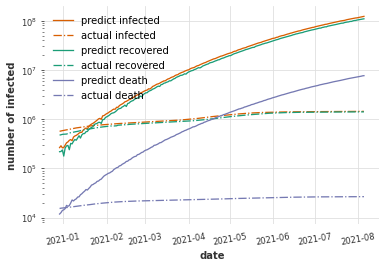

In [147]:
import matplotlib.pyplot as plt

# copy from Sidarthe model
input_steps=1
output_steps=2

start_index = VAL_IDX+input_steps+output_steps
x = last_update_pydatetime[start_index:]

plt.plot(x, predictions[input_steps+output_steps:,0], label ='predict infected', color=confirmed_color )
plt.plot(x, canada[start_index:][:,0], '-.', label ='actual infected', color=confirmed_color )
plt.plot(x, predictions[input_steps+output_steps:,1], label ='predict recovered', color=healed_color)
plt.plot(x, canada[start_index:][:,1], '-.', label ='actual recovered', color=healed_color)
plt.plot(x, predictions[input_steps+output_steps:,2], label ='predict death', color=death_color)
plt.plot(x, canada[start_index:][:,2], '-.', label ='actual death', color=death_color)
plt.yscale('log')
plt.xlabel("date")
plt.ylabel("number of infected")
plt.legend()
plt.xticks(rotation=10)
tikzplotlib.save("tft.tikz")
plt.legend()
plt.show()

In [149]:
mean_squared_error(predictions[3:,0], canada[VAL_IDX:][3:,0], squared=False)

46690140.86441061

In [150]:
mean_squared_error(predictions[3:,1], canada[VAL_IDX:][3:,1], squared=False)

41675153.81865376

In [148]:
mean_squared_error(predictions[3:,2], canada[VAL_IDX:][3:,2], squared=False)

2958386.1495794775

---

### ARIMA

In [78]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot


def arima_prediction(column):
    model = ARIMA(canada[:TRAIN_IDX, column], order=(32,0,0))
    model_fit = model.fit(method='burg')
    predictions = []
    for t in range(VAL_IDX, len(canada)):
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        model = ARIMA(canada[TRAIN_IDX:t,column], order=(32,0,0))
        model_fit = model.fit(method='burg')
    return predictions

In [79]:
infected = arima_prediction(0)

In [80]:
healed = arima_prediction(1)

In [81]:
death = arima_prediction(2)

In [82]:
predictions = np.stack([infected, healed, death], axis=1)

In [85]:
inversed_predict_arima = mm_scaler.inverse_transform(predictions)

In [83]:
import tikzplotlib

confirmed_color=(217/256,95/256,2/256)
healed_color=(27/256,158/256,119/256)
death_color=(117/256,112/236,179/256)

In [95]:
from datetime import datetime

canada_csv = pd.read_csv('canada.csv')
date_series = pd.to_datetime(canada_csv['Last_Update'])
last_update_pydatetime = [datetime(year=x.year, month=x.month, day=x.day, hour=x.hour, minute=x.minute, second=x.second)
                          for x in date_series]

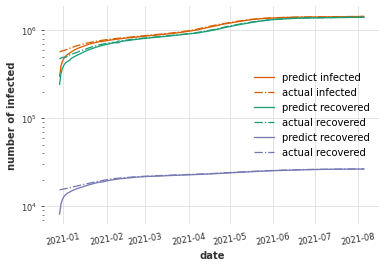

In [102]:
import matplotlib.pyplot as plt

# copy from Sidarthe model
input_steps=1
output_steps=2

start_index = VAL_IDX+input_steps+output_steps
x = last_update_pydatetime[start_index:]

plt.plot(x, predictions[input_steps+output_steps:,0], label ='predict infected', color=confirmed_color )
plt.plot(x, canada[start_index:][:,0], '-.', label ='actual infected', color=confirmed_color )
plt.plot(x, predictions[input_steps+output_steps:,1], label ='predict recovered', color=healed_color)
plt.plot(x, canada[start_index:][:,1], '-.', label ='actual recovered', color=healed_color)
plt.plot(x, predictions[input_steps+output_steps:,2], label ='predict death', color=death_color)
plt.plot(x, canada[start_index:][:,2], '-.', label ='actual death', color=death_color)
plt.yscale('log')
plt.xlabel("date")
plt.ylabel("number of infected")
plt.legend()
plt.xticks(rotation=10)
tikzplotlib.save("arima.tikz")
plt.legend()
plt.show()

In [103]:
mean_squared_error(predictions[3:,0], canada[VAL_IDX:][3:,0], squared=False)

32189.883983899264

In [92]:
mean_squared_error(predictions[3:,1], canada[VAL_IDX:][3:,1], squared=False)

28208.251824218773

In [94]:
mean_squared_error(predictions[3:,2], canada[VAL_IDX:][3:,2], squared=False)

809.9104266812906